In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.cluster import KMeans # а также другие алгоритмы

/tmp/ipykernel_11162/1174587749.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

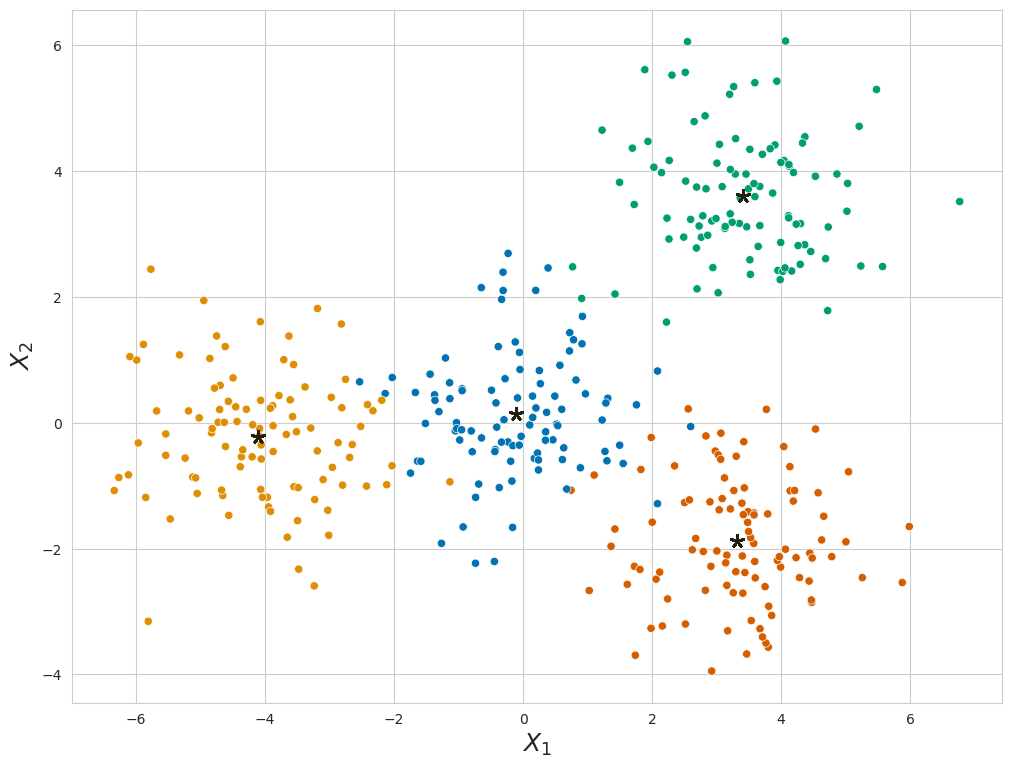

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        cluster_labels = None
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        cluster_labels = np.argmin(dists, axis=1) #делаем все то же, что и цикле выше
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        """
        YOUR CODE IS HERE
        """
        dist = None
        dist = np.sqrt(((X - centroid)**2).sum(axis=1))
    
        return dist.reshape(X.shape[0], 1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

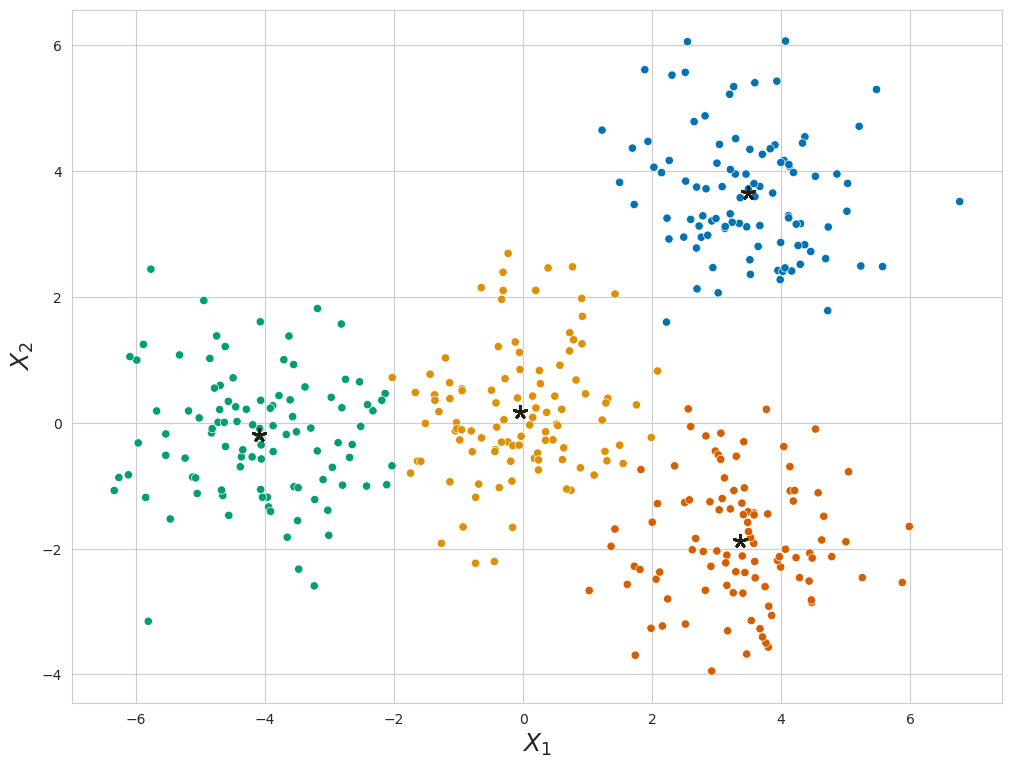

Силуэт =  0.5643117184043004


In [7]:
k_means_rand = MyKMeans(4, init="random", max_iter=20, visualize=True)
k_means_rand.fit(X)
k_means_predict_rand = k_means_rand.predict(X)
#используем метрику силуэт, чтобы показать, как хорошо классифицирован каждый объект
sil_rand = silhouette_score(X, k_means_predict_rand)
print(f'Силуэт =  {sil_rand}')


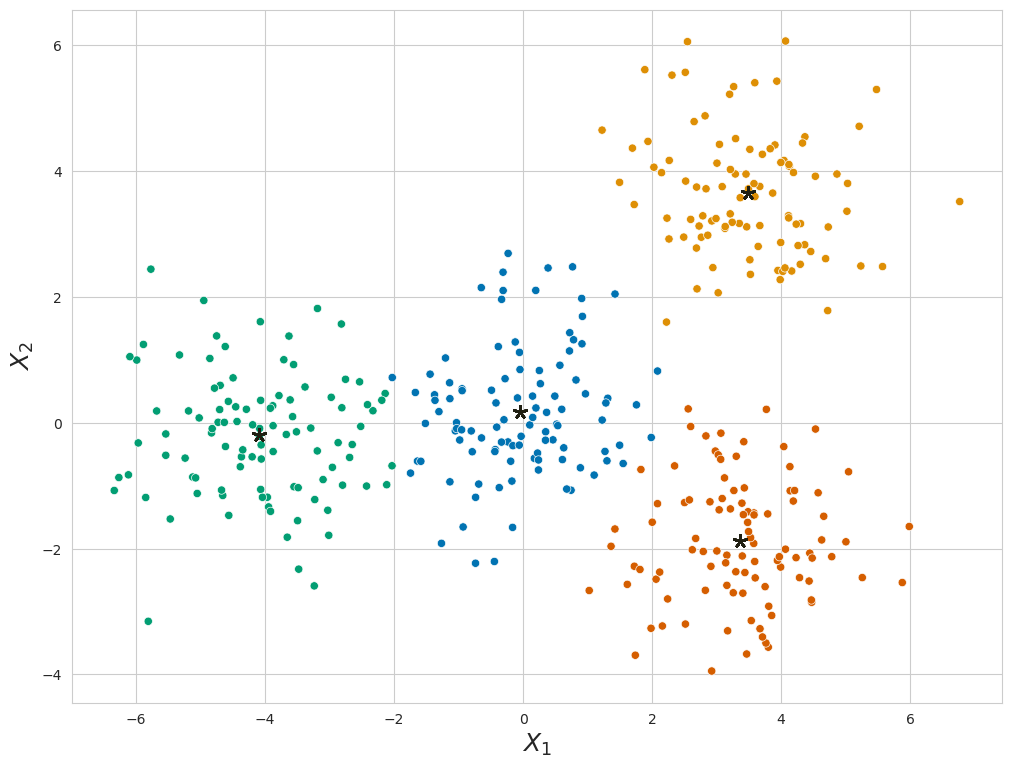

Силуэт =  0.5643117184043004


In [8]:
k_means_sample = MyKMeans(4, init="sample", max_iter=20, visualize=True)
k_means_sample.fit(X)
k_means_predict_sample = k_means_sample.predict(X)
#центр кластера - настоящая координата , графически от рандомного выбора k-mean разницы нет 
sil_sample = silhouette_score(X, k_means_predict_sample)
print(f'Силуэт =  {sil_sample}')
#метрики отличаются незначительно, что может быть связано с игрушечным набором данных :) 
#Википедия говорит, что значение силуэта больше 0,5 - это "разумно", объекты кластера похожи и обладают сплоченностью


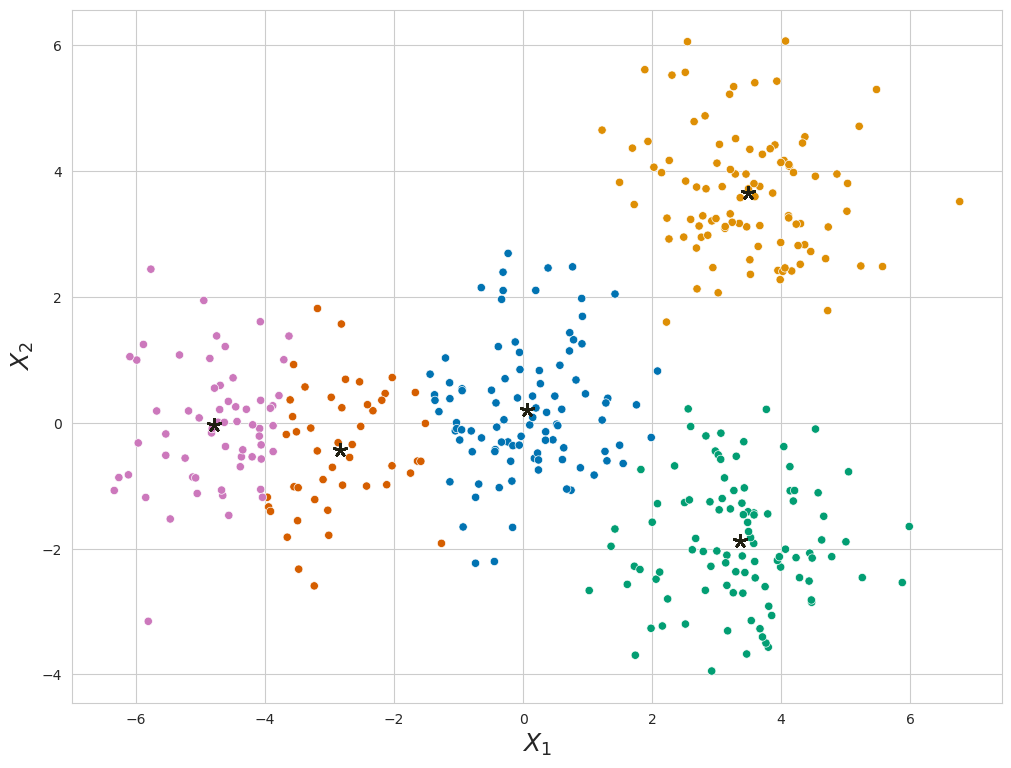

Силуэт =  0.48660825767939875


In [9]:
#Попробуем увеличить количество кластеров на единицу
k_means_sample = MyKMeans(5, init="sample", max_iter=20, visualize=True)
k_means_sample.fit(X)
k_means_predict_sample_5 = k_means_sample.predict(X)
sil_sample_5 = silhouette_score(X, k_means_predict_sample_5)
print(f'Силуэт =  {sil_sample_5}')
#Видим, что нижний правый кластер поделился на 2 части, что даже визуально выглядит не очень убедительно, значение силуэта упало, уменьшилась схожесть объектов в кластерах

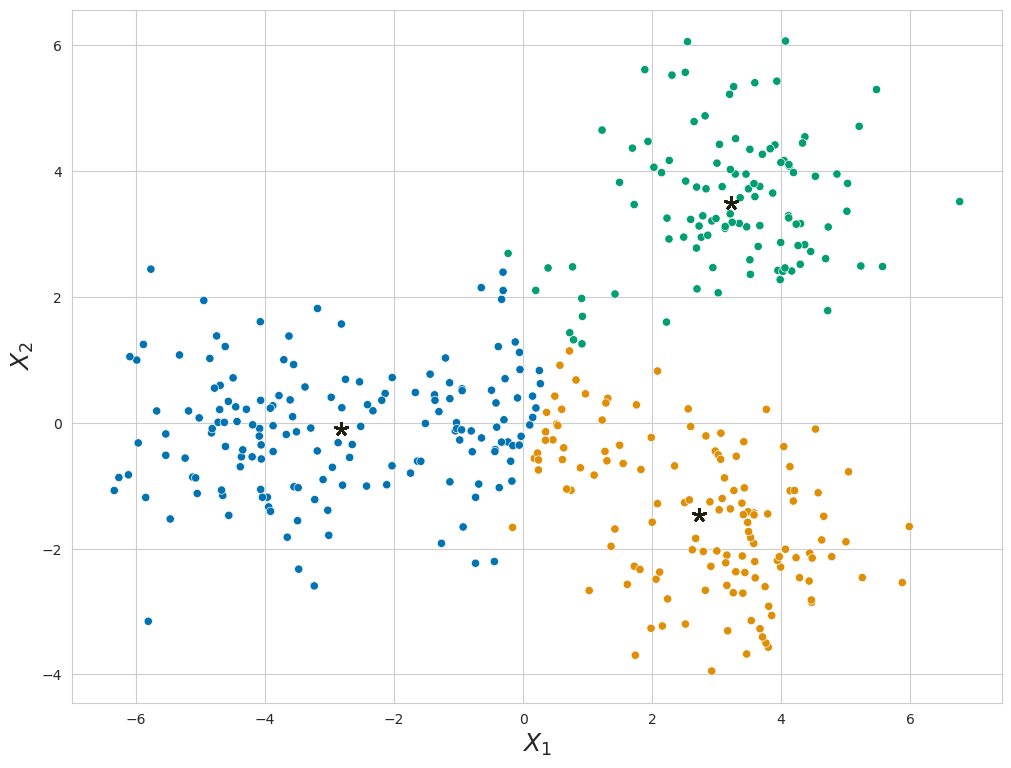

Силуэт =  0.48660825767939875


In [10]:
#Возьмем меньшее число кластеров
k_means_sample_3 = MyKMeans(3, init="sample", max_iter=20, visualize=True)
k_means_sample_3.fit(X)
k_means_predict_sample_3 = k_means_sample.predict(X)
sil_sample_3 = silhouette_score(X, k_means_predict_sample_3)
print(f'Силуэт =  {sil_sample_3}')
#Получили тоже что-то недостаточно убедительное, значение силуэта ниже

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [11]:
data = load_digits()
X, y = data.data, data.target

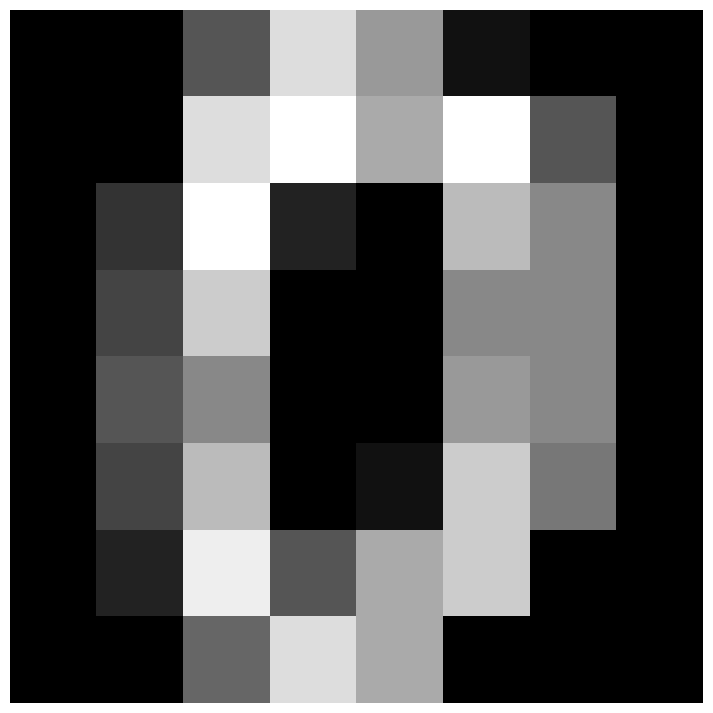

In [12]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [13]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering
def algorithm_selection(X, y=None, distances=('euclidean', 'manhattan', 'l1', 'cosine'), algorithms=['average', 'single', 'complete'], metrics = ['homogenity', 'completeness', 'v_measure', 'silhouette']):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE
    """
    metrics_result = []
    for dists in distances:
        for algorithm in algorithms:
            model = AgglomerativeClustering(n_clusters=6, metric=dists, linkage=algorithm)
            y_pred = model.fit_predict(X)
            for metric in metrics:
                metric_dict = {'Distance': dists, 'Algorithm': algorithm, 'Metric': metric}
                if metric == 'homogenity':
                    if y is not None:
                        metric_dict['Value'] = homogeneity_score(y, y_pred)
                    else:
                        metric_dict['Value'] = None
                elif metric == 'completeness':
                    if y is not None:
                        metric_dict['Value'] = completeness_score(y, y_pred)
                    else:
                        metric_dict['Value'] = None
                elif metric == 'v_measure':
                    if y is not None:
                        metric_dict['Value'] = v_measure_score(y, y_pred)
                    else:
                        metric_dict['Value'] = None
                elif metric == 'silhouette':
                    metric_dict['Value'] = silhouette_score(X, y_pred)
                
                metrics_result.append(metric_dict)

    compare_df = pd.DataFrame(metrics_result)
    return compare_df

In [14]:
algorithm_selection(X, y)
#для n = 3, лучшая мера расстояния - манхэттенское, l1, алгоритм average, метрика completeness
#для n = 5, лучшая мера расстояния - евклидово, манхэттенское, l1, cosine, алгоритм average, метрика completeness
#для n = 10, лучшая мера расстояния - евклидово, cosine, l1, алгоритм average, completeness 

Distance Algorithm        Metric     Value
0   euclidean   average    homogenity  0.655393
1   euclidean   average  completeness  0.782342
2   euclidean   average     v_measure  0.713263
3   euclidean   average    silhouette  0.146625
4   euclidean    single    homogenity  0.005056
5   euclidean    single  completeness  0.273755
6   euclidean    single     v_measure  0.009929
7   euclidean    single    silhouette -0.133621
8   euclidean  complete    homogenity  0.590549
9   euclidean  complete  completeness  0.637772
10  euclidean  complete     v_measure  0.613253
11  euclidean  complete    silhouette  0.119271
12  manhattan   average    homogenity  0.566751
13  manhattan   average  completeness  0.778942
14  manhattan   average     v_measure  0.656117
15  manhattan   average    silhouette  0.089217
16  manhattan    single    homogenity  0.005102
17  manhattan    single  completeness  0.276237
18  manhattan    single     v_measure  0.010019
19  manhattan    single    silhouette -0.166627
20  manhattan  complete    homogenity  0.646372
21  manhattan  complete  completeness  0.686109
22  manhattan  complete     v_measure  0.665648
23  manhattan  complete    silhouette  0.140183
24         l1   average    homogenity  0.566751
25         l1   average  completeness  0.778942
26         l1   average     v_measure  0.656117
27         l1   average    silhouette  0.089217
28         l1    single    homogenity  0.005102
29         l1    single  completeness  0.276237
30         l1    single     v_measure  0.010019
31         l1    single    silhouette -0.166627
32         l1  complete    homogenity  0.646372
33         l1  complete  completeness  0.686109
34         l1  complete     v_measure  0.665648
35         l1  complete    silhouette  0.140183
36     cosine   average    homogenity  0.648268
37     cosine   average  completeness  0.808762
38     cosine   average     v_measure  0.719676
39     cosine   average    silhouette  0.129526
40     cosine    single    homogenity  0.005050
41     cosine    single  completeness  0.273389
42     cosine    single     v_measure  0.009916
43     cosine    single    silhouette -0.158250
44     cosine  complete    homogenity  0.528727
45     cosine  complete  completeness  0.577415
46     cosine  complete     v_measure  0.551999
47     cosine  complete    silhouette  0.088021

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [15]:
fc_data = pd.read_csv("../data/flow_c_data.csv", index_col=0)

##### YOUR TURN TO CODE:

In [16]:
fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

<Axes: >

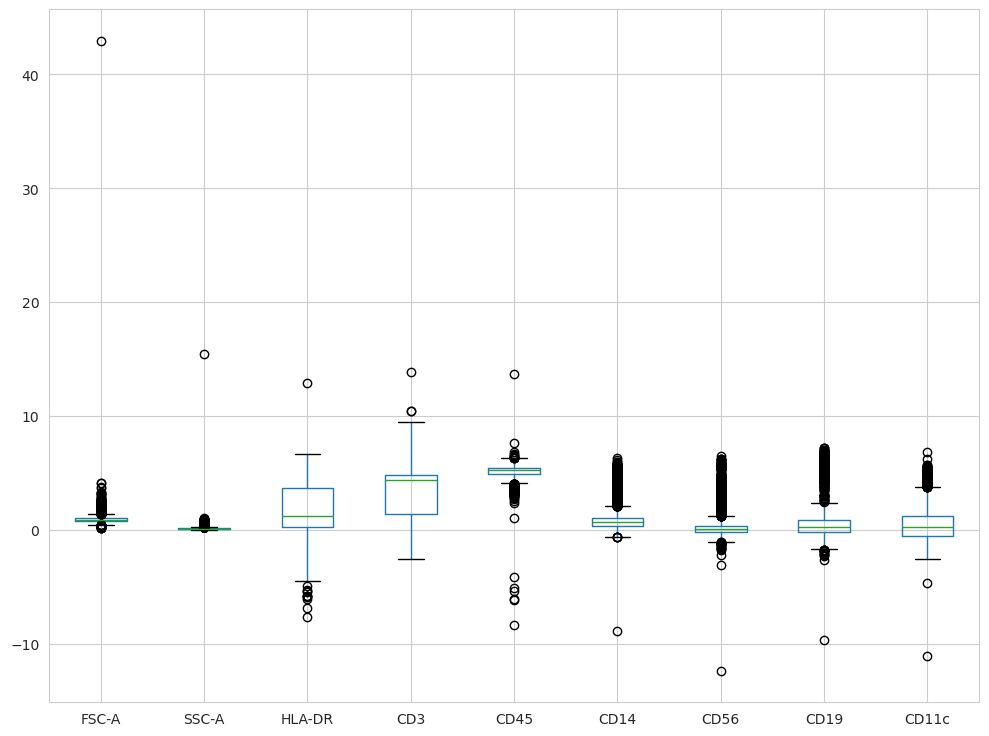

In [17]:
fc_data.boxplot()



------------------------------ WELCOME TO EDA! ------------------------------
------------------------------ mmm... ------------------------------
------------------------------ your data is so delicious... ------------------------------

                    (
           (      )     )
             )   (    (
            (          `
        .-""^"""^""^"""^""-.
      (//\\//\\//\\//\\//\\//)
       ~\^^^^^^^^^^^^^^^^^^/~
         `================`
    
------------------------------ WELCOME TO EDA! ------------------------------


--------------------- Found 'Factor' columns --------------------- 

--------------------- Found 'Number' columns --------------------- 
'FSC-A' column
Min: 0.144785712890625
Max: 42.954485
Mean: 0.96
Std: 0.5
q0.25: 0.8
Median: 0.91
q0.75: 1.05

'SSC-A' column
Min: 0.0216570068359375
Max: 15.4609975
Mean: 0.17
Std: 0.19
q0.25: 0.11
Median: 0.13
q0.75: 0.16

'HLA-DR' column
Min: -7.634172362624425
Max: 12.946668062243972
Mean: 1.79
Std: 2.03
q0.25: 0.28
M

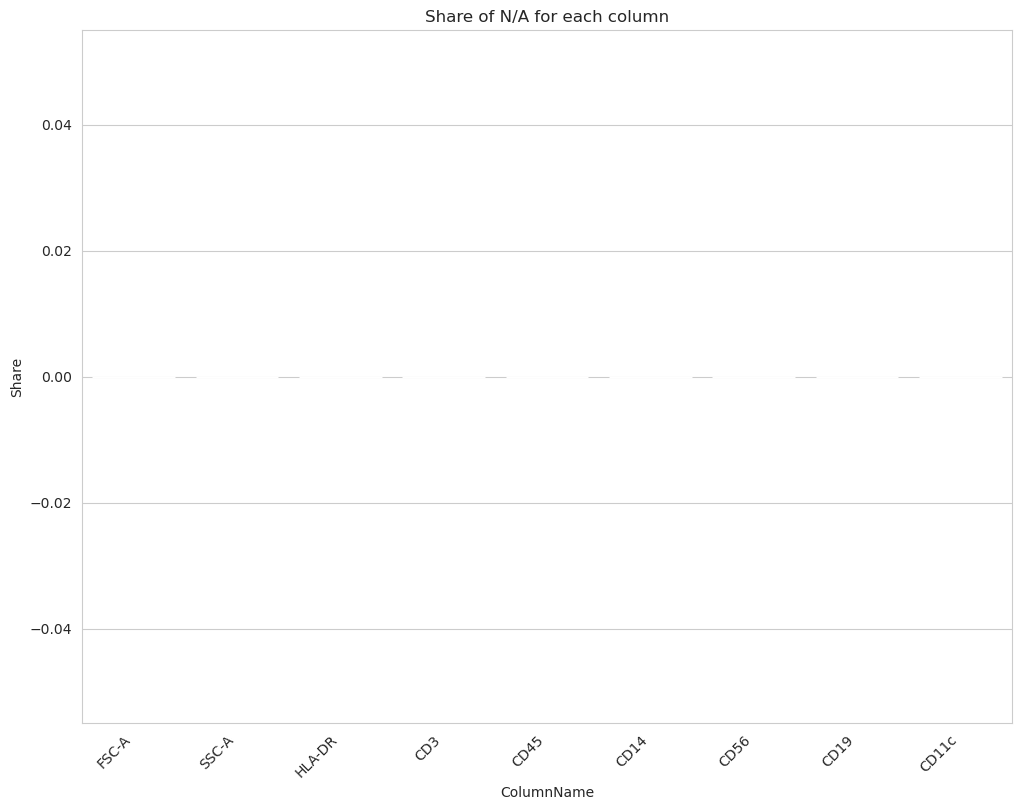

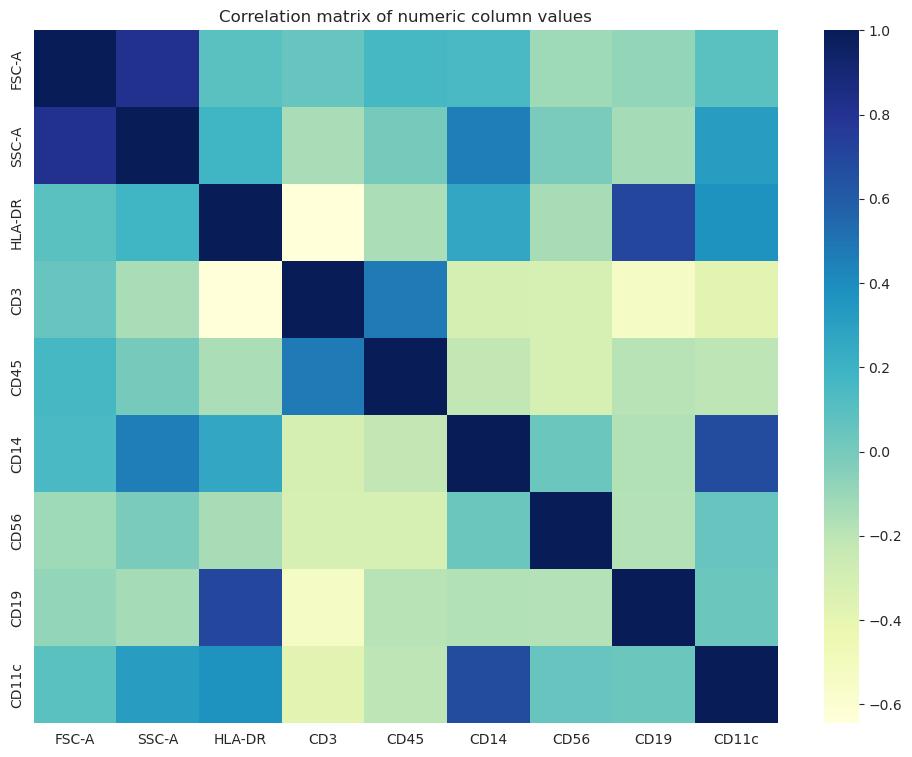

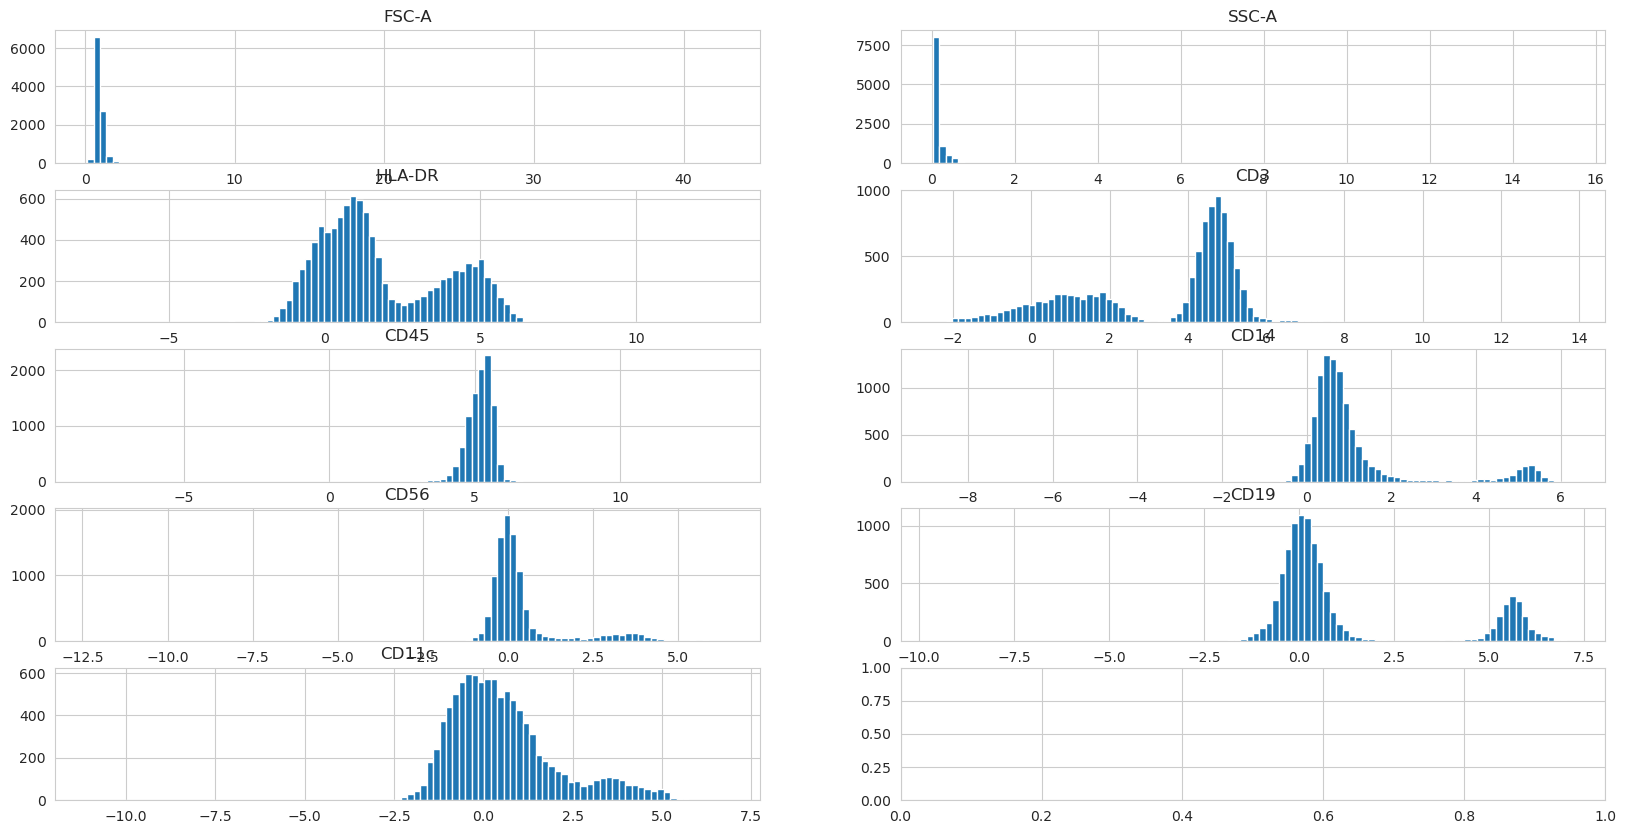

In [18]:
from my_awesome_eda import run_eda
run_eda(fc_data)

In [19]:
#EDA и boxplot показывает на наличие выбросов 
get_outliers = [np.argmax(fc_data['FSC-A']), np.argmax(fc_data['CD3']), np.argmin(fc_data['CD14']), np.argmin(fc_data['CD56']), np.argmin(fc_data['CD45'])]
fc_data.iloc[get_outliers]
#дропаем выбросы
fc_data_without_outliers = fc_data.drop(labels=get_outliers, axis=0)

In [20]:
#Cтандартизуем наши данные, на лекции говорили, что это must have
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fc_data_without_outliers_scaled = pd.DataFrame(scaler.fit_transform(fc_data_without_outliers), columns=fc_data_without_outliers.columns)

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [21]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

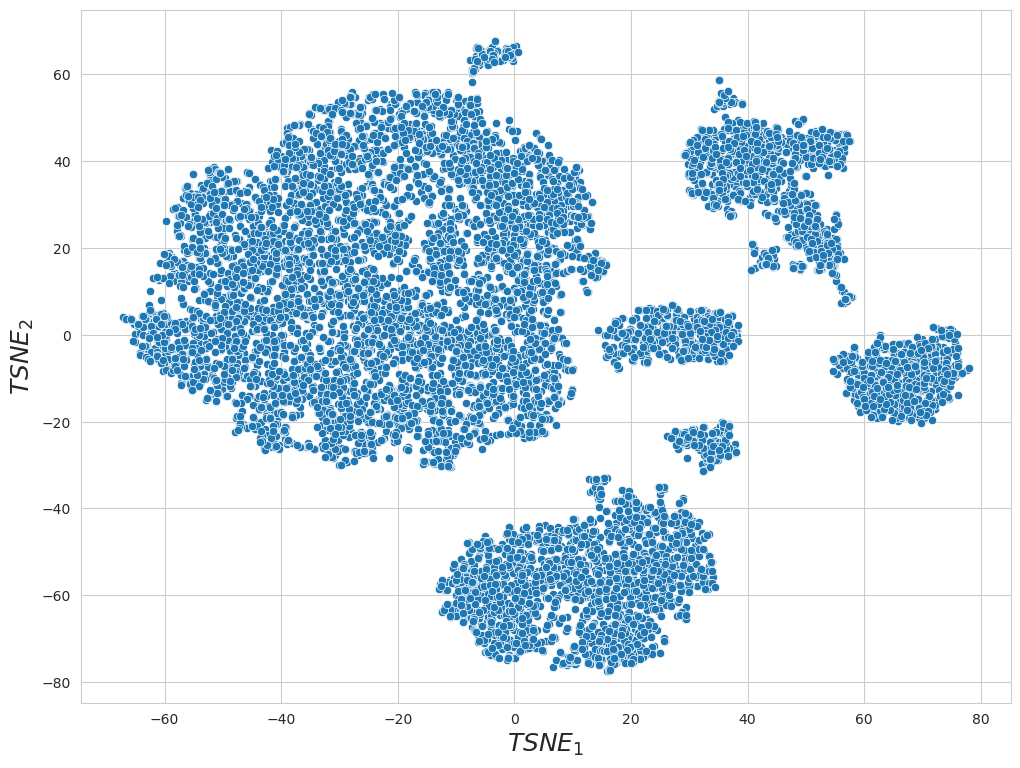

In [22]:
tsne_res = plot_tsne(fc_data_without_outliers_scaled) #Видно, что тут примерно 6 групп

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

**K-means**

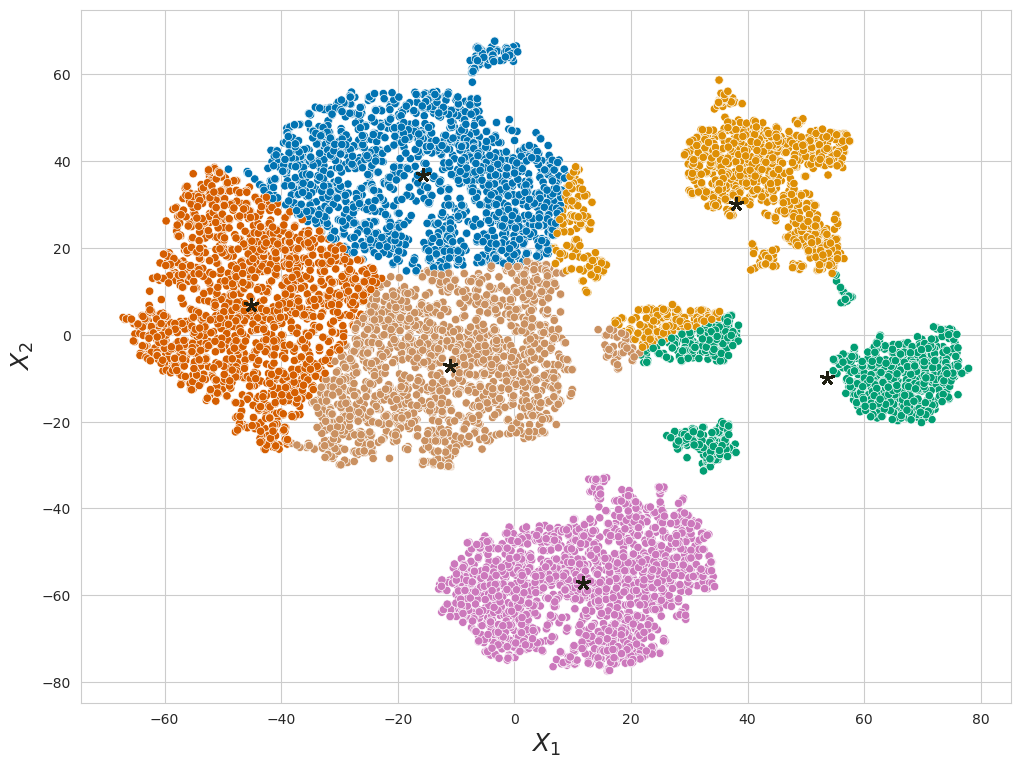

0.19174421057804877

In [23]:
kmeans_sample = MyKMeans(6, init="sample", max_iter=5, visualize=True)
kmeans_sample.fit(tsne_res)
km_pred = kmeans_sample.predict(tsne_res)
silhouette_score(fc_data_without_outliers_scaled, km_pred) #не получилось на 6 групп адекватно разделить, силуэт = 0,19

**AgglomerativeClustering**

In [32]:
cells_clust = algorithm_selection(fc_data_without_outliers_scaled, metrics=['silhouette']) #в algorithm_selection я поменяла n_clusters = 6
cells_clust.sort_values('Value', ascending=False).head(10) #лучше всего метрики для single и average алгоритма и для метрик расстояния, евклидово, manhattan и l1 

Distance Algorithm      Metric     Value
1   euclidean    single  silhouette  0.484108
4   manhattan    single  silhouette  0.484108
7          l1    single  silhouette  0.484108
3   manhattan   average  silhouette  0.473348
6          l1   average  silhouette  0.473348
0   euclidean   average  silhouette  0.472471
5   manhattan  complete  silhouette  0.384118
8          l1  complete  silhouette  0.384118
2   euclidean  complete  silhouette  0.335454
11     cosine  complete  silhouette  0.185122

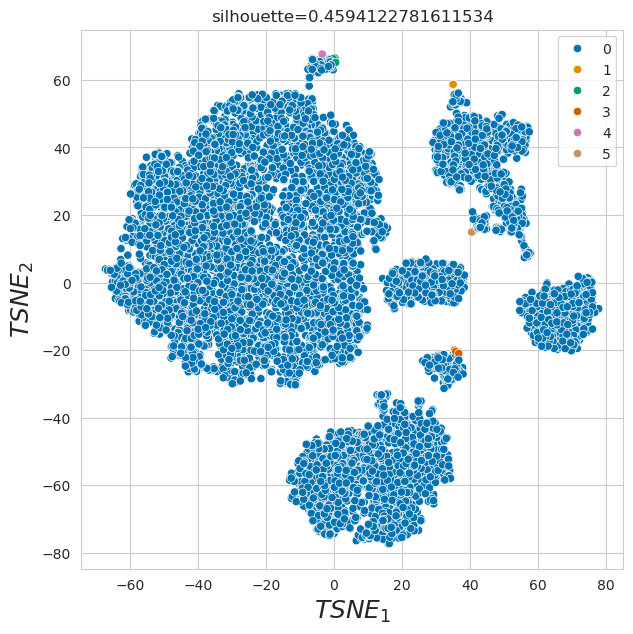

In [33]:
agg_model = AgglomerativeClustering(n_clusters=6, metric='l1', linkage='average')
predicted_agg_value = agg_model.fit_predict(fc_data_without_outliers_scaled)
sil = silhouette_score(fc_data_without_outliers_scaled, predicted_agg_value)

plt.figure(figsize=(7,7))
plt.title(f'silhouette={sil}')
tsne_res_ac = plot_tsne(fc_data_without_outliers_scaled, color=predicted_agg_value)
#Получается что-то не очень ожидаемое

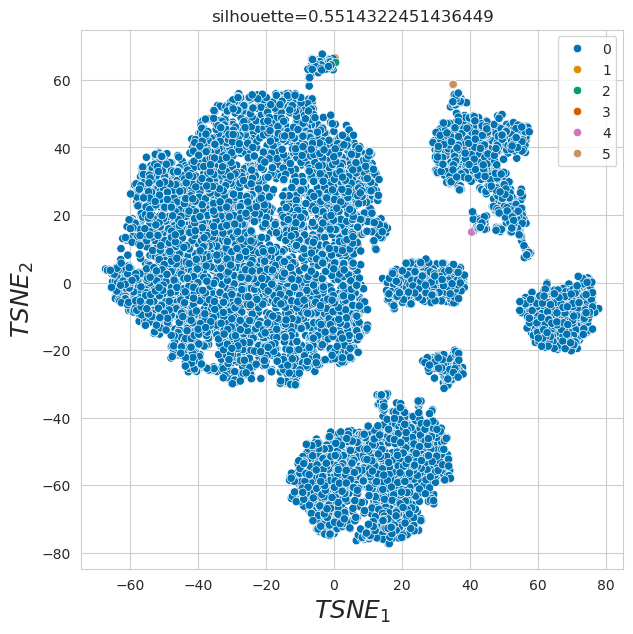

In [35]:
agg_model = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='single')
predicted_agg_value = agg_model.fit_predict(fc_data_without_outliers_scaled)
sil = silhouette_score(fc_data_without_outliers_scaled, predicted_agg_value)

plt.figure(figsize=(7,7))
plt.title(f'silhouette={sil}')
tsne_res_ac = plot_tsne(fc_data_without_outliers_scaled, color=predicted_agg_value)

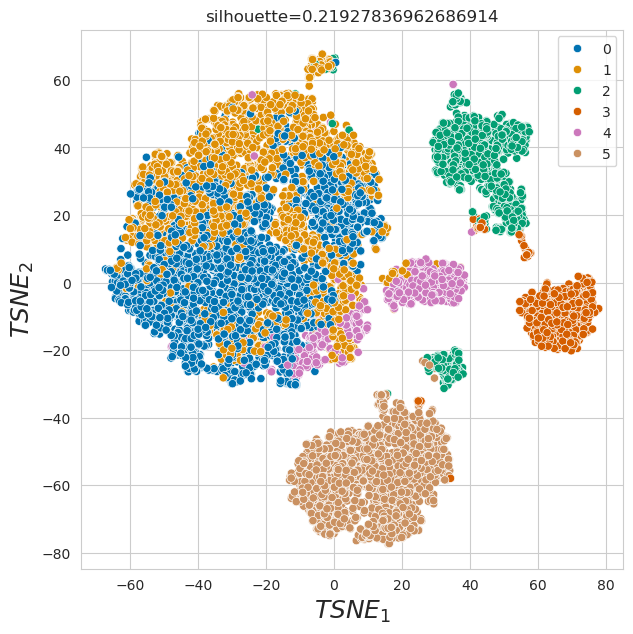

In [37]:
agg_model = AgglomerativeClustering(n_clusters=6, metric='cosine', linkage='complete')
predicted_agg_value = agg_model.fit_predict(fc_data_without_outliers_scaled)
sil = silhouette_score(fc_data_without_outliers_scaled, predicted_agg_value)

plt.figure(figsize=(7,7))
plt.title(f'silhouette={sil}')
tsne_res_ac = plot_tsne(fc_data_without_outliers_scaled, color=predicted_agg_value) #тоже что-то странное

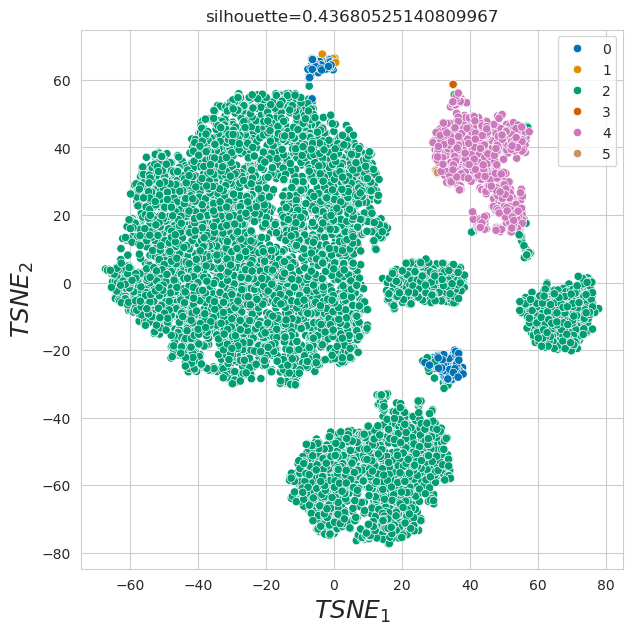

In [50]:
agg_model3 = AgglomerativeClustering(n_clusters=6, metric='manhattan', linkage='complete')
predicted_agg_value = agg_model3.fit_predict(fc_data_without_outliers_scaled)
sil = silhouette_score(fc_data_without_outliers_scaled, predicted_agg_value)

plt.figure(figsize=(7,7))
plt.title(f'silhouette={sil}')
tsne_res_ac = plot_tsne(fc_data_without_outliers_scaled, color=predicted_agg_value) #и это тоже что-то странное

Попробовала разделить на 4

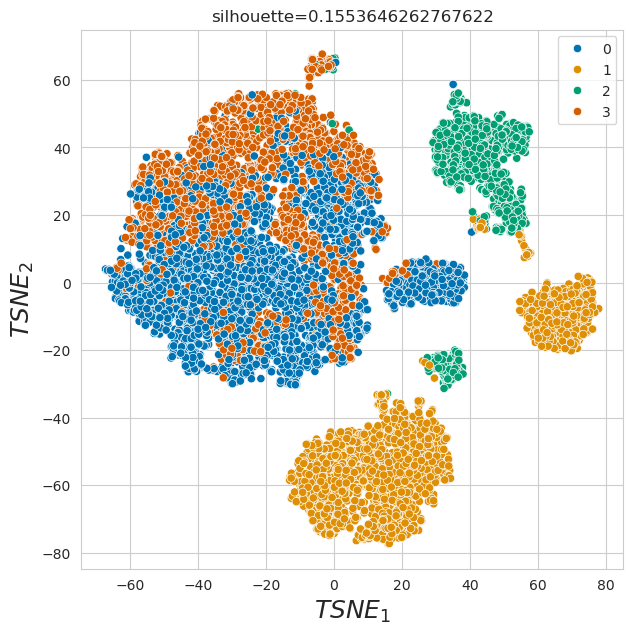

In [55]:
agg_model4 = AgglomerativeClustering(n_clusters=4, metric='cosine', linkage='complete')
predicted_agg_value = agg_model4.fit_predict(fc_data_without_outliers_scaled)
sil = silhouette_score(fc_data_without_outliers_scaled, predicted_agg_value)

plt.figure(figsize=(7,7))
plt.title(f'silhouette={sil}')
tsne_res_ac = plot_tsne(fc_data_without_outliers_scaled, color=predicted_agg_value) #и это тоже что-то странное

Попробуем разобраться с **DBSCAN**

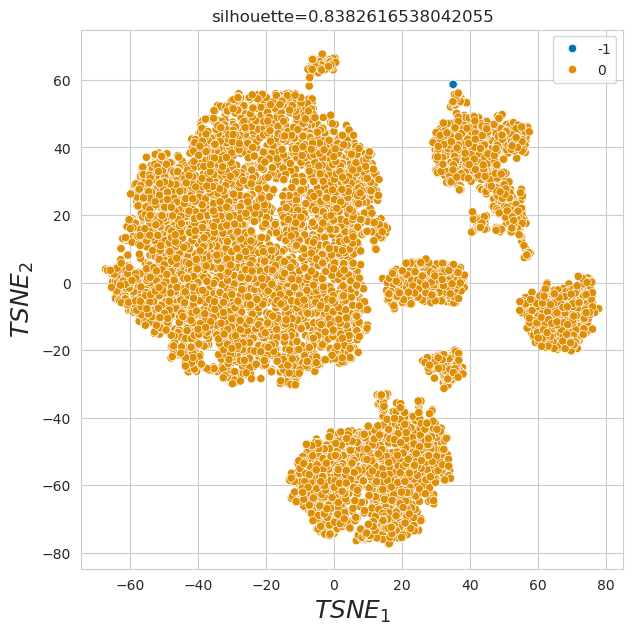

In [42]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=6, min_samples=30, metric='euclidean')
predict_dbscan = dbscan.fit_predict(fc_data_without_outliers_scaled)
sil = silhouette_score(fc_data_without_outliers_scaled, predict_dbscan)

plt.figure(figsize=(7,7))
plt.title(f'silhouette={sil}')
tsne_res_ac = plot_tsne(fc_data_without_outliers_scaled, color=predict_dbscan) #мде, не верить глазам или алгоритмам?



Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

`Нет :0, зато поигралась`

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

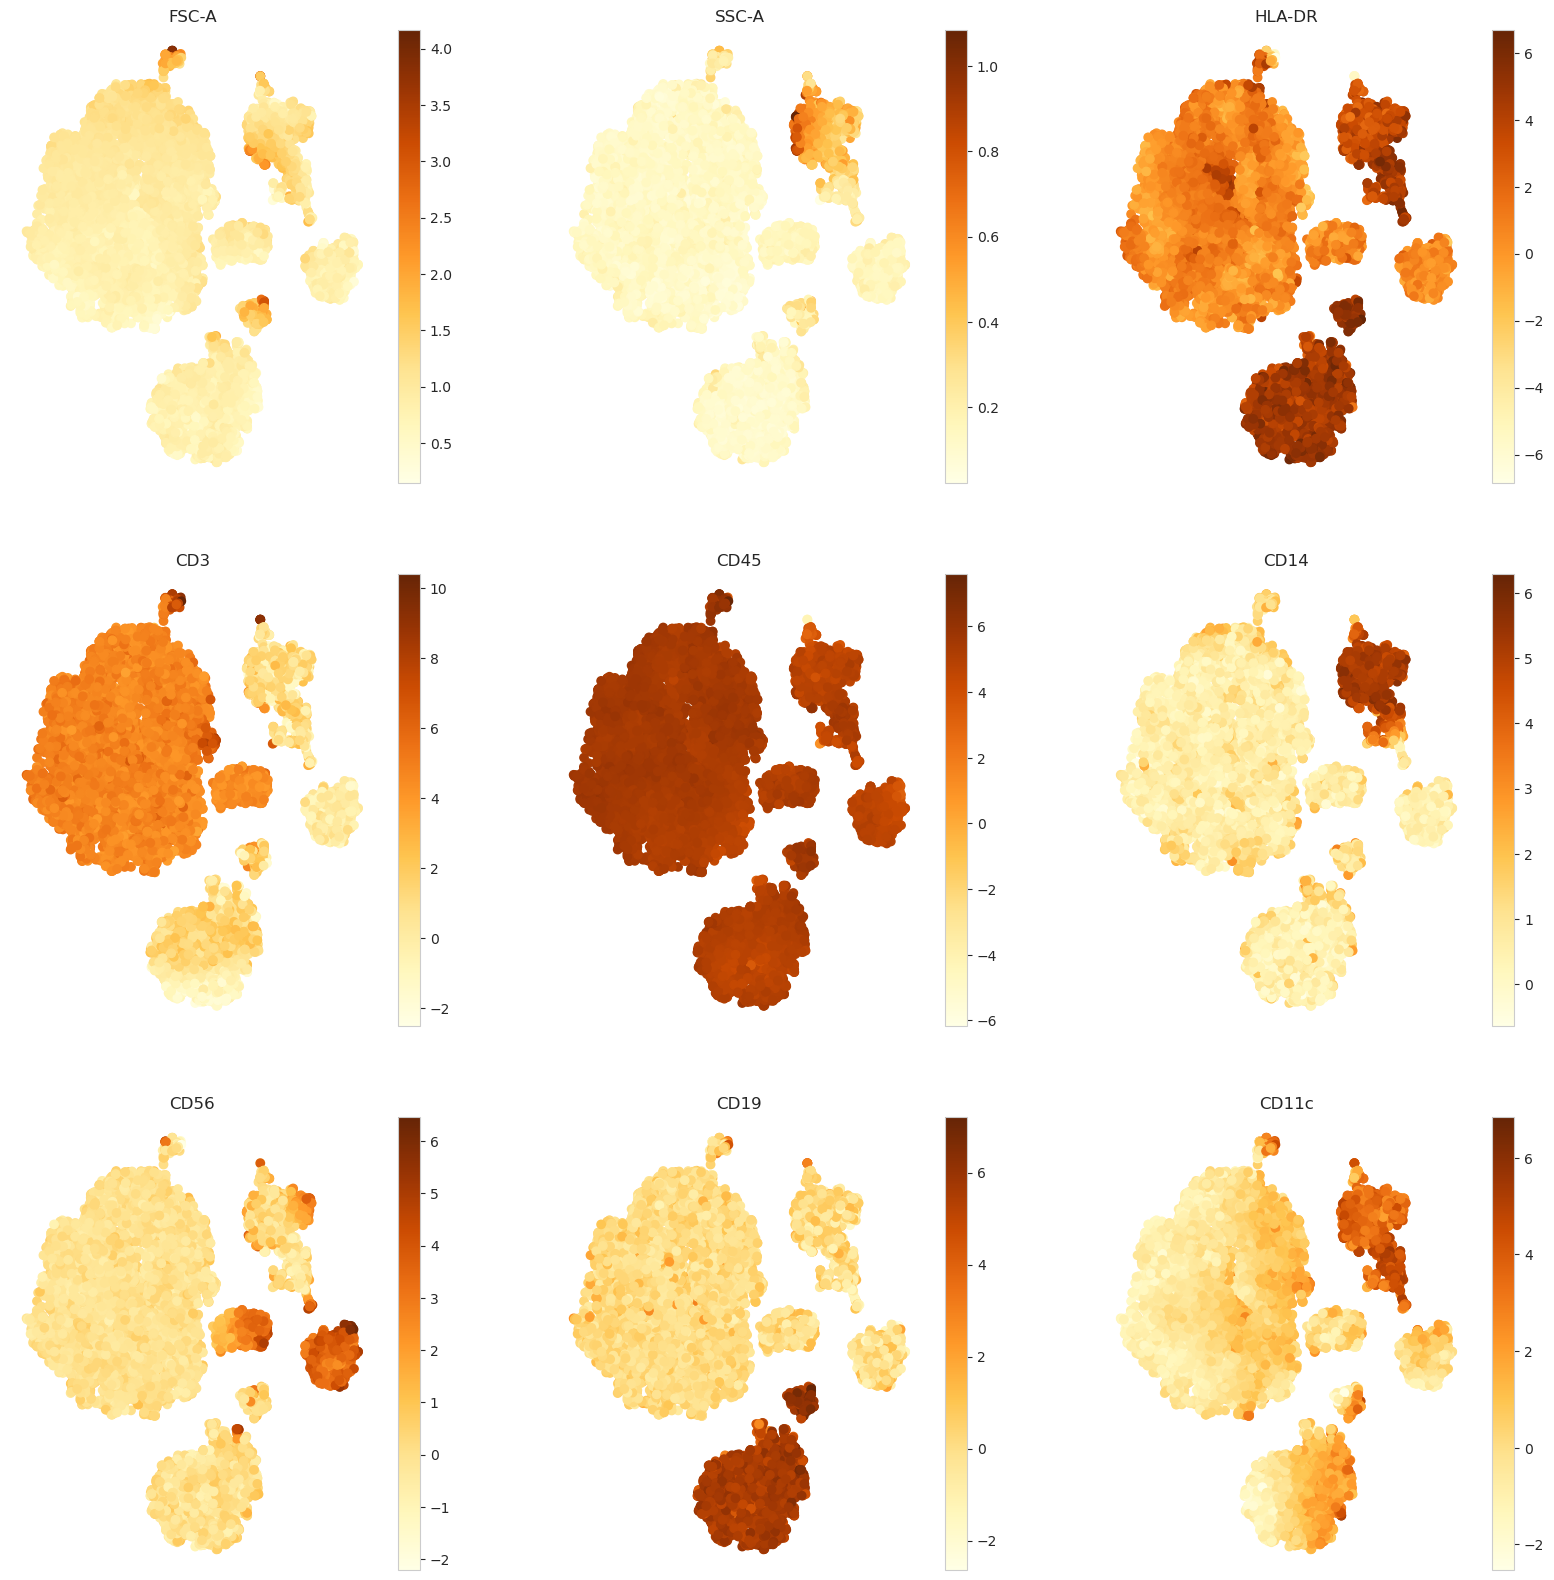

In [45]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_without_outliers.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_without_outliers[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [56]:
cell_type_cluster_map = {0: "Other cells", #CD3
                         1: "Monocytes", #CD14
                         2: "B_cells", #CD19
                         3: "T_cells"} #CD56

In [57]:
labeled_fc_data = fc_data_without_outliers.assign(Population=agg_model4.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)
labeled_fc_data

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0     0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1     0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2     1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3     0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4     0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.180762  0.441445  2.437344  1.526085  4.455114  4.880495  0.347480   
9996  0.768279  0.111863  0.812236  4.254496  5.008437  1.303261 -0.130244   
9997  1.314964  0.233584  4.144130  1.311947  5.340263  1.598675 -0.287353   
9998  0.894135  0.137300 -0.226186  0.246804  4.430212  0.457881  2.404284   
9999  0.826941  0.186522 -0.243523  0.606306  4.466970  0.104687  3.738260   

          CD19     CD11c   Population  
0    -1.406912  0.384406    Monocytes  
1     6.034845  0.577039    Monocytes  
2    -0.318668 -0.493832      T_cells  
3     0.694883  3.416960  Other cells  
4     5.563345  0.471591    Monocytes  
...        ...       ...          ...  
9995 -0.591343  2.857737      B_cells  
9996  0.344169 -0.626795      T_cells  
9997 -0.887078  4.369294      B_cells  
9998 -0.112999  0.069239    Monocytes  
9999 -0.441455  0.378331    Monocytes  

[9998 rows x 10 columns]

Посчитайте, как распределены типы клеток:

In [58]:
labeled_fc_data[['Population']].value_counts() 

Population 
Other cells    3730
Monocytes      2554
T_cells        2479
B_cells        1235
Name: count, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [60]:
labeled_fc_data.to_csv(join("../data/", "labeled_fc_data.csv"))

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [61]:
from sklearn.model_selection import train_test_split
num_cols = ['FSC-A', 'SSC-A', 'HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19', 'CD11c']
X = labeled_fc_data[num_cols]
y = labeled_fc_data['Population'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [63]:
pipeline.fit(X_train, y_train)
regression_predict = pipeline.predict(X_test)


In [64]:
from sklearn.metrics import f1_score
f1_score(y_test, regression_predict, average="macro")

0.9004172976052859

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Влюбилась в Сахару и особенности ландшафта Туниса, когда была там в прошлом году, добавила фотографию в папку с кодом
![Моя картинка](./photo_2024-02-26_14-45-50.jpg)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Было здорово, модельки - это круто, но непонятно, как сделать хорошую. Про метрики тоже пока не очень понятно, разберем на консультации. Круто, что всех ассистентов познакомили, теперь не так страшно будет писать в чятик